In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import os
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import h5py
import math
import pickle
from datetime import datetime
from numba import cuda 

%matplotlib inline

In [2]:
import sys  
sys.path.insert(0, '..')

In [3]:
from tiling.read_tiles import TissueDataset, load_color_normalization_values

In [4]:
# Code snippet nvidia gpu
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
HDF5_FOLDER = '/media/nico/data/fourthbrain/project/training_CAMELYON16'

In [5]:
train_data = TissueDataset(HDF5_FOLDER,  percentage=0.8, first_part=True, crop_size=224)
val_data = TissueDataset(HDF5_FOLDER, percentage=0.2, first_part=False, crop_size=224)

In [6]:
log_dir = "/media/nico/data/fourthbrain/project/model_testing/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [7]:
batch_size_neg=50
batch_size_pos=50
batches_per_train_epoch = 100
batches_per_val_epoch = 50
MAX_EPOCHS = 20

In [8]:
green_layer_only = False
color_normalization_file="CAMELYON16_color_normalization.json"

In [9]:
def history_to_pickle(history, filepath):
    with open(filepath, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
        
def pickle_to_history(filepath):
    history = pickle.load(open(filepath, "rb"))
    return history

In [10]:
def plot_history(history):
    # list all data in history
    print(history.keys())
    # summarize history for accuracy
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


In [11]:
model = keras.applications.InceptionV3(input_shape=(224,224,3),
                                        include_top=True,
                                        classes = 1,
                                        classifier_activation="sigmoid",
                                        weights=None)  

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [13]:
now1 = datetime.now()
model_type = 'train_no_filters_rgb_not_normalized_level_3'
model_hdf5 = '/media/nico/data/fourthbrain/project/model_testing/model_{}_'.format(model_type) + now1.strftime("%Y%m%d-%H%M%S") + '.hdf5'
filepath = '/media/nico/data/fourthbrain/project/model_testing/{}.pkl'.format(model_type)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_hdf5, monitor='loss',verbose=1, save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, 
                           verbose=1, mode='max', min_lr=1e-5)

#all callbacks
callbacks = [tensorboard_callback, model_checkpoint, reduce_lr]        
history = model.fit(x=train_data.generator(batch_size_neg, batch_size_pos, True, green_layer_only=False, color_normalization_file=None),
                    validation_data=val_data.generator(batch_size_neg, batch_size_pos, False, green_layer_only=False, color_normalization_file=None),
                    epochs=MAX_EPOCHS,
                    steps_per_epoch = batches_per_train_epoch,
                    validation_steps = batches_per_val_epoch,
                    callbacks=callbacks
                   )
dtme = now1.strftime('%m%d%Y_%H%M%S.pkl')
now2 = datetime.now()
print('duration: {} - path: {}'.format(now2 - now1, filepath))
history_to_pickle(history, filepath)

Epoch 1/20
100/100 [==============================] - 37s 302ms/step - loss: 0.3144 - accuracy: 0.8508 - val_loss: 1.3009 - val_accuracy: 0.5000

Epoch 00001: loss improved from inf to 0.24352, saving model to /media/nico/data/fourthbrain/project/model_testing/model_train_no_filters_rgb_not_normalized_level_3_20210123-003854.hdf5
Epoch 2/20
100/100 [==============================] - 28s 285ms/step - loss: 0.1906 - accuracy: 0.9294 - val_loss: 0.6510 - val_accuracy: 0.7308

Epoch 00002: loss improved from 0.24352 to 0.16778, saving model to /media/nico/data/fourthbrain/project/model_testing/model_train_no_filters_rgb_not_normalized_level_3_20210123-003854.hdf5
Epoch 3/20
100/100 [==============================] - 29s 286ms/step - loss: 0.1393 - accuracy: 0.9454 - val_loss: 1.0266 - val_accuracy: 0.6920

Epoch 00003: loss improved from 0.16778 to 0.12862, saving model to /media/nico/data/fourthbrain/project/model_testing/model_train_no_filters_rgb_not_normalized_level_3_20210123-003854.h

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


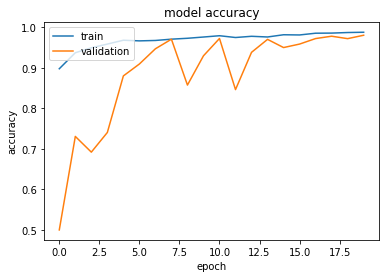

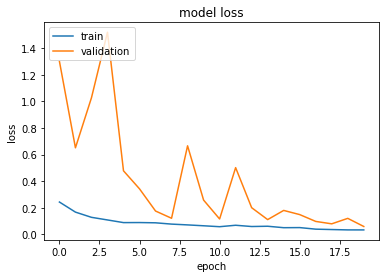

In [14]:
plot_history(history.history)

In [15]:
model.save('/media/nico/data/fourthbrain/project/model_testing/model_no_filter_no_color_norm.hdf5')

In [53]:
HDF5_FOLDER = '/media/nico/data/fourthbrain/project/testing_CAMELYON16'

In [ ]:
test_data = TissueDataset(HDF5_FOLDER, percentage=0.1, first_part=False, crop_size=224)

In [ ]:
iter_norm = test_data.generator(num_neg=2000, num_pos=2000, data_augm=False, color_normalization_file=None)

In [ ]:
i = 0
Y, Y_pred = list(), list()
for x, y in iter_norm:
    y_pred = model.predict(x)
    i +=1
    if i == 1:
        break

In [ ]:
y_pred = np.around(y_pred.flatten())

In [ ]:
y

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(y, y_pred))

In [10]:
color_normalization_file="CAMELYON16_color_normalization.json"

In [19]:
m = '/media/nico/data/fourthbrain/project/model_testing/model.hdf5'
model = tf.keras.models.load_model(m)

In [14]:
iter_norm = test_data.generator(num_neg=1, num_pos=1, data_augm=False, color_normalization_file=color_normalization_file)

In [36]:
def plot_samples(itera, num_samples=2):
    plt.figure(figsize=(12,4))
    for x, y in itera:
        print(x.shape)
        for i in range(num_samples):
            ax = plt.subplot(1, num_samples, i + 1)
            plt.tight_layout()
            ax.set_title('Sample #{} - class {}'.format(i, y[i]))
            ax.imshow(x[i])
            ax.axis('off') 
        break # generate yields infinite random samples, so we stop after first

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 224, 224, 3)


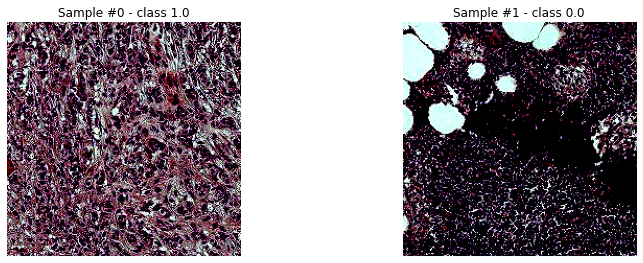

In [37]:
plot_samples(iter_norm, num_samples=2)

In [40]:
i = 0
for x, y in iter_norm:
    pred = model.predict(x)
    y0 = 0 if pred[0]< 0.5 else 1
    y1 = 0 if pred[1]< 0.5 else 1
    print(y, np.array([y0, y1]))
    i +=1
    if i == 1:
        break

[1. 0.] [1 0]


In [31]:
from PIL import Image, ImageDraw, ImageFont
def np_to_pil(np_img):
    """
    Convert a NumPy array to a PIL Image.
    Args:
    np_img: The image represented as a NumPy array.

    Returns:
     The NumPy array converted to a PIL Image.
    """
    if np_img.dtype == "bool":
        np_img = np_img.astype("uint8") * 255
    elif np_img.dtype == "float64":
        np_img = (np_img * 255).astype("uint8")
    return Image.fromarray(np_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

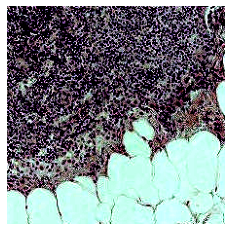

In [42]:
plt.imshow(x[1])
plt.axis('off')

In [53]:
from keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

In [ ]:
y_pred

In [56]:
def build_features_figure(feat_model, path_image):
    # Example of features on the last conv2D layer - 83 according to model.summary
    model = Model(inputs=feat_model.inputs, outputs=feat_model.layers[83].output)
    # load the image with the required shape
    img = image.load_img(path_image, target_size=(224, 224))
    # convert the image to an array
    img = image.img_to_array(img)
    # expand dimensions so that it represents a single 'sample'
    img = np.expand_dims(img, axis=0)
    # prepare the image (e.g. scale pixel values for the vgg)
    img = preprocess_input(img)
    # get feature map for first hidden layer
    feature_maps = model.predict(img)
    # plot all 64 maps in an 8x8 squares
    square = 8
    ix = 1
    f, axs = plt.subplots(2,2,figsize=(15,15))
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(feature_maps[0, :, :, ix-1]) #, cmap='gray')
            ix += 1
    # show the figure
    plt.show()

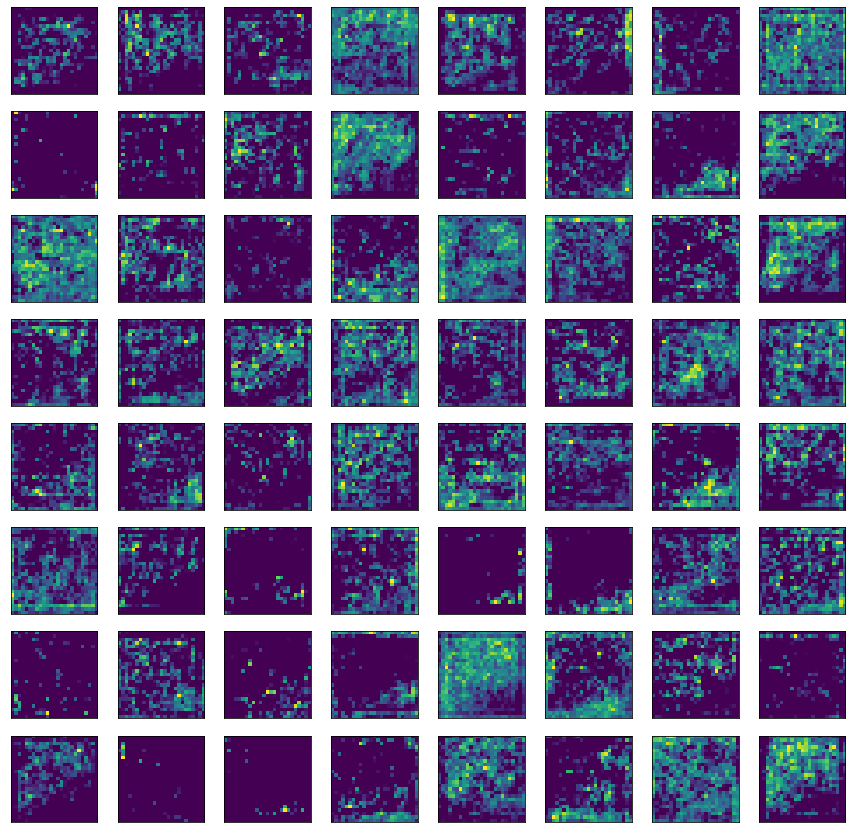

In [57]:
build_features_figure(model, '/media/nico/data/fourthbrain/project/model_testing/normal.png')

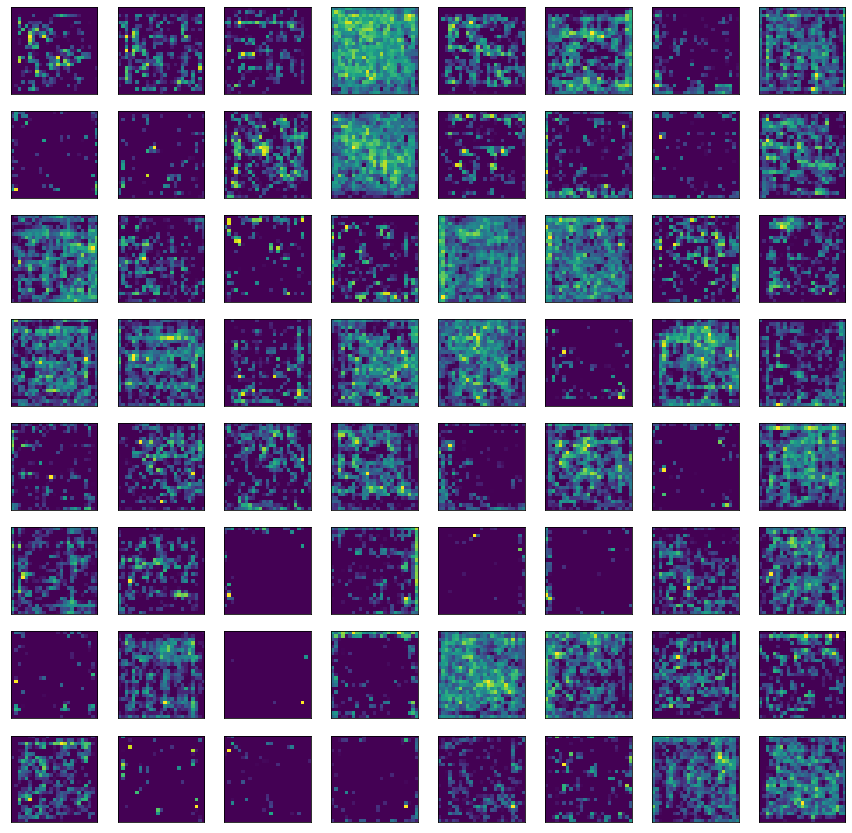

In [58]:
build_features_figure(model, '/media/nico/data/fourthbrain/project/model_testing/tumor.png')